## **1. Installation and imports**

In [1]:
import os
import sys
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# Imports for the probing model
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyRegressor

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr

# Import for the model
from transformers import BertTokenizer, BertForSequenceClassification
from src.config import load_config
from src.model import PatentSentenceClassifier

## **1. Loading the model**

In [2]:
# Load Config
cfg = load_config('config.yaml')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# load Tokenizer and Base Model
bert_tokenizer = BertTokenizer.from_pretrained(cfg.model.name)
base_model = BertForSequenceClassification.from_pretrained(cfg.model.name, num_labels=cfg.model.num_lables, output_hidden_states=True)
print('\nTokenizer and Base Model loaded succesfully.')

# Load Finetuned Patent Model
checkpoint_path = '/home/fantoni/patent-sentence-classification/models/best-checkpoint.ckpt'
loaded_model = PatentSentenceClassifier.load_from_checkpoint(checkpoint_path, model=base_model, tokenizer=bert_tokenizer)
loaded_model.eval()
loaded_model.to(device)
print('\nModel loaded succesfully.')

Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at anferico/bert-for-patents and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Tokenizer and Base Model loaded succesfully.

Model loaded succesfully.


## **2. Dataset**

In [3]:
# Import test set
df = pd.read_excel('/home/fantoni/patent-sentence-classification/data/test.xlsx')
print(f"Tot. number of sentences: {len(df)}")
df.head(10)

Tot. number of sentences: 600


,sent_id,sent,sent_tag,sent_class
0,250614,The rigid foam layer 50 is typically selected ...,STR,1
1,1894531,The bracket 80 is affixed to the troffer shelf...,MIX,2
2,1620340,figure 5 is a diagram illustrating an exemplar...,STR,1
3,1846361,"In one exemplary implementation, the subject m...",FUN,0
4,276595,The motion sickness control system may include...,STR,1
5,357834,Some embodiments of the invention include a ph...,STR,1
6,2674079,Multi-role amplifier 900 provides an RCA pre-a...,FUN,0
7,1847887,The hook region 310 may include two or more cu...,STR,1
8,384624,A foam product based on epoxidized vegetable o...,STR,1
9,1848061,A firth object of the present invention is to ...,STR,1


## **3. Extraction of the internal representations**


In [ ]:
embeddings = []
sent_ids = []
sentences = []

# Iterate over the rows of the DataFrame
for _, row in df.iterrows():
    sent_id = row['sent_id']
    sent = row['sent']
    inputs = bert_tokenizer(sent, truncation=True, padding=True, max_length=cfg.model.max_length, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
      outputs = loaded_model(**inputs)
      embeddings.append(outputs["hidden_states"])
      sent_ids.append(sent_id)
      sentences.append(sent)

# Saving the representations 
with open("./data/probing/patent_sentence_classifier_representations.pkl", "wb") as fOut:
   pickle.dump({'sent_ids': sent_ids, 'sentences': sentences, 'embeddings': embeddings}, fOut)

### **3.1. Exploring Model output**

In [5]:
# Load the internal representation from the pickle file
with open("./data/probing/patent_sentence_classifier_representations.pkl", "rb") as fIn:
    data = pickle.load(fIn)

In [6]:
# Sample sentence selection (e.g., idx 0)
idx = 0
sample_sent_id = data['sent_ids'][idx]
sample_sent = data['sentences'][idx]
sample_embed = data['embeddings'][idx]

# Visualize the output of the tokenization process on the sample sentence extracted from the dataset
inputs = bert_tokenizer(sample_sent, truncation=True, padding=True, max_length=cfg.model.max_length)
sample_tokens = bert_tokenizer.convert_ids_to_tokens(inputs['input_ids'])
print("Tokens:", sample_tokens)
print()

# Number of layers of the model
n_layers = len(sample_embed)
print("Num. of layers:", n_layers)
print()

# Word representations of a specific selected layer
layer = 12
hidden_state = sample_embed[layer]
print(hidden_state)
print()

# Visualize the dimension of the 'hidden_state' object (i.e. number of sentences * number of tokens * number of hidden units)
print("Tensor dimension:", hidden_state.shape)
print()

# Visualize the embedding of a specific token of the selected sample sentence
word_embeddings = {k:v for k, v in zip(sample_tokens, hidden_state[0])}
word = "rigid"
print(word_embeddings[word])

Tokens: ['[CLS]', 'the', 'rigid', 'foam', 'layer', '50', 'is', 'typically', 'selected', 'from', 'the', 'group', 'of', 'polyurethane', 'foam', '##s', ',', 'poly', '##ure', '##a', 'foam', '##s', ',', 'and', 'combinations', 'thereof', '.', '[SEP]']

Num. of layers: 25

tensor([[[-1.2254e+00, -7.3113e-01, -1.1376e-01,  ..., -8.1394e-01,
           3.2103e-01,  4.8897e-01],
         [-1.0978e+00, -7.5884e-02,  3.6041e-01,  ..., -1.9457e-02,
           3.4474e-01, -4.5244e-01],
         [-2.3735e+00,  3.4584e-01,  2.0662e+00,  ..., -1.2569e+00,
          -2.5748e-01, -9.1929e-02],
         ...,
         [ 7.2475e-01, -1.4836e-02,  9.6384e-01,  ..., -2.8394e-01,
          -6.2202e-01, -8.7424e-01],
         [-1.5871e+00, -1.3779e-01, -6.9405e-01,  ..., -5.9435e-01,
           3.2638e-01, -6.0360e-03],
         [-2.1649e-02, -1.7379e-02,  2.2928e-03,  ...,  4.3678e-02,
           3.0989e-02,  8.4781e-02]]])

Tensor dimension: torch.Size([1, 28, 1024])

tensor([-2.3735,  0.3458,  2.0662,  ..., 

## **5. Train the probing model**

In [5]:
def probing(embeddings, df, ids, feature, layer):
  # Dataset containing only the selected linguistic feature
  df_feature = df[feature]

  X = []
  y = []
  
  for id, sentence in zip(ids, embeddings):
    embedding_layer = sentence[layer][0]

    # We extract the representation from the [CLS] token, that is the first token in each input sequence, having set 'add_special_tokens' equal to 'True' during tokenization
    cls_embedding = embedding_layer[0].tolist()

    # Access to the value of the linguistic feature 'feature' for the given sentence, based on the id
    feat = df_feature.loc[id]

    X.append(cls_embedding)
    y.append(feat)

  # Diving the dataset into train and test files
  X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, ids, test_size=0.20, random_state=42)

  # Defining the probing model
  probing_model = LinearSVC(dual=False, loss='squared_hinge')
  
  # Fit the model on the training data and then predict on X_test
  probing_model.fit(X_train, y_train)
  y_pred = probing_model.predict(X_test)

  # Evaluation of the predictions
  corr, p_val = spearmanr(y_test, y_pred)

  # Save the predictions for further analysis
  df_preds = pd.DataFrame(columns=["sent_id", "y_true", "y_pred"])
  df_preds["sent_id"] = ids_test
  df_preds["y_true"] = y_test
  df_preds["y_pred"] = y_pred
  df_preds.to_csv(f'./data/probing/results_{layer}_{feature}.tsv', sep='\t', index=True)
  
  return corr, p_val


def baseline(df, feature):
  # Select "n_tokens" as X for the baseline probing model
  X = df["n_tokens"].to_numpy()
  X = X.reshape(-1, 1)
  y = df[feature].to_numpy()

  # Diving the dataset into train and test files
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
  
  # Defining the probing model
  probing_model = LinearSVC(dual=False, loss='squared_hinge')
  
  # Fit the model on the training data and then predict on X_test
  probing_model.fit(X_train, y_train)
  y_pred = probing_model.predict(X_test)

  # Evaluation of the predictions
  corr, p_val = spearmanr(y_test, y_pred)
  
  return corr, p_val

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler

def cross_validate_probing(embeddings, df, ids, feature, layer, n_splits=3):
    # Dataset containing only the selected linguistic feature
    df_feature = df[feature]

    # Prepare data
    X = []
    y = []
    
    for id, sentence in zip(ids, embeddings):
        embedding_layer = sentence[layer][0]
        # Extract [CLS] token embedding
        cls_embedding = embedding_layer[0].tolist()
        
        # Access feature value for the given sentence
        feat = df_feature.loc[id]
        
        X.append(cls_embedding)
        y.append(feat)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    ids = np.array(ids)
    
    # Initialize results storage
    correlation_scores = []
    p_values = []
    predictions_all = []
    true_values_all = []
    ids_all = []
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        ids_test = ids[test_idx]
                
        # Train model
        probing_model = LinearSVC(dual=False, loss='squared_hinge')
        probing_model.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = probing_model.predict(X_test)
        corr, p_val = spearmanr(y_test, y_pred)
        
        # Store results
        correlation_scores.append(corr)
        p_values.append(p_val)
        predictions_all.extend(y_pred)
        true_values_all.extend(y_test)
        ids_all.extend(ids_test)
        
        print(f"Fold {fold}: Correlation = {corr:.4f}, p-value = {p_val:.4f}")
    
    # Create results DataFrame
    df_preds = pd.DataFrame({
        "sent_id": ids_all,
        "y_true": true_values_all,
        "y_pred": predictions_all
    })
    
    # Save results
    df_preds.to_csv(f'./data/probing/results_{layer}_{feature}.tsv', sep='\t', index=False)
    
    # Compute overall statistics
    mean_correlation = np.mean(correlation_scores)
    std_correlation = np.std(correlation_scores)
    mean_p_value = np.mean(p_values)
    
    return {
        'correlations': correlation_scores,
        'p_values': p_values,
        'mean_correlation': mean_correlation,
        'std_correlation': std_correlation,
        'mean_p_value': mean_p_value,
    }

In [7]:
# Load the internal representation from the pickle file
with open("./data/probing/patent_sentence_classifier_representations.pkl", "rb") as fIn:
    data = pickle.load(fIn)

sent_ids = data['sent_ids']
sentences = data['sentences']
embeddings = data['embeddings']
n_layers = len(data['embeddings'][0])

In [8]:
# Import test set and create the 'n_tokens' feature for the baseline model
df = pd.read_excel('/home/fantoni/patent-sentence-classification/data/test.xlsx')

def count_tokens(text):
    tokenized_text = re.split(r'([,.:;?_!"()\']|--|\s)', text)
    tokenized_text = [item.strip() for item in tokenized_text if item.strip()] # eliminates with spaces
    return len(tokenized_text)

# Add n_tokens feature for the baseline model
df['n_tokens'] = df['sent'].apply(count_tokens)
df = df.set_index("sent_id")  # necessary for the probing functions
df

,sent,sent_tag,sent_class,n_tokens
sent_id,,,,
250614,The rigid foam layer 50 is typically selected ...,STR,1,22
1894531,The bracket 80 is affixed to the troffer shelf...,MIX,2,39
1620340,figure 5 is a diagram illustrating an exemplar...,STR,1,21
1846361,"In one exemplary implementation, the subject m...",FUN,0,41
276595,The motion sickness control system may include...,STR,1,19
...,...,...,...,...
1417745,The holding capacity is in part achieved by pi...,MIX,2,46
2372426,"For example, web server 502 can be a server th...",FUN,0,25
346466,The cut piece is observed using a transmission...,FUN,0,43


In [ ]:
selected_features = ["n_tokens", "sent_class"] # set fetures
layers = list(range(n_layers)[1:]) # set number of layers

# Create an empty pandas DataFrame to store the probing results
results_df = pd.DataFrame(index=selected_features, columns=layers + ["Baseline"])

# Iterate over the selected features
for feature in selected_features:
  # Iterate over the layers of the model
  for layer in layers:
    print(f"\nFeature: {feature} - Layer: {layer}")
    
    #1. Standard Probing
    #corr, p_val = probing(embeddings=embeddings, df=df, ids=sent_ids, feature=feature, layer=layer)
    
    #2 Probing with cross-validation
    prob_results = cross_validate_probing(embeddings=embeddings, df=df, ids=sent_ids, feature=feature, layer=layer, n_splits=3)
    corr = prob_results['mean_correlation']
    p_val = prob_results['mean_p_value']
    print(f"Mean correlation = {corr:.4f}")
    print(f"Mean p-value = {p_val:.4f}")

    # Save the score only if the correlation is statistically significant (p-value < 0.05)
    if p_val < 0.05:
      results_df.loc[feature][layer] = corr

  # Simple baseline model trained to predict the selected linguistic feature using only "n_tokens" as input feature
  corr_baseline, p_val_baseline = baseline(df, feature)
  if p_val < 0.05:
    results_df.loc[feature]["Baseline"] = corr_baseline


Feature: n_tokens - Layer: 1
Fold 1: Correlation = 0.8180, p-value = 0.0000
Fold 2: Correlation = 0.8174, p-value = 0.0000
Fold 3: Correlation = 0.8524, p-value = 0.0000
Mean correlation: 0.8293
Mean p-value: 0.0000

Feature: n_tokens - Layer: 2
Fold 1: Correlation = 0.8622, p-value = 0.0000
Fold 2: Correlation = 0.8405, p-value = 0.0000
Fold 3: Correlation = 0.8178, p-value = 0.0000
Mean correlation: 0.8402
Mean p-value: 0.0000

Feature: n_tokens - Layer: 3
Fold 1: Correlation = 0.7875, p-value = 0.0000
Fold 2: Correlation = 0.8109, p-value = 0.0000
Fold 3: Correlation = 0.8734, p-value = 0.0000
Mean correlation: 0.8239
Mean p-value: 0.0000

Feature: n_tokens - Layer: 4
Fold 1: Correlation = 0.8307, p-value = 0.0000
Fold 2: Correlation = 0.8126, p-value = 0.0000
Fold 3: Correlation = 0.8293, p-value = 0.0000
Mean correlation: 0.8242
Mean p-value: 0.0000

Feature: n_tokens - Layer: 5
Fold 1: Correlation = 0.8155, p-value = 0.0000
Fold 2: Correlation = 0.7890, p-value = 0.0000
Fold 3: 

## **6. Results visualization**

In [10]:
# Visualize the results memorized in the DataFrame
results_df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,Baseline
n_tokens,0.829287,0.840188,0.823923,0.824189,0.81207,0.806306,0.832727,0.772192,0.738864,0.662785,...,0.600161,0.568459,0.574534,0.564607,0.514911,0.480297,0.443624,0.445383,0.459985,0.967284
sent_class,0.406414,0.425625,0.466759,0.450881,0.453944,0.454281,0.436191,0.476434,0.409601,0.469312,...,0.383024,0.441034,0.414095,0.401704,0.40469,0.419935,0.400692,0.423694,0.424209,-0.124715


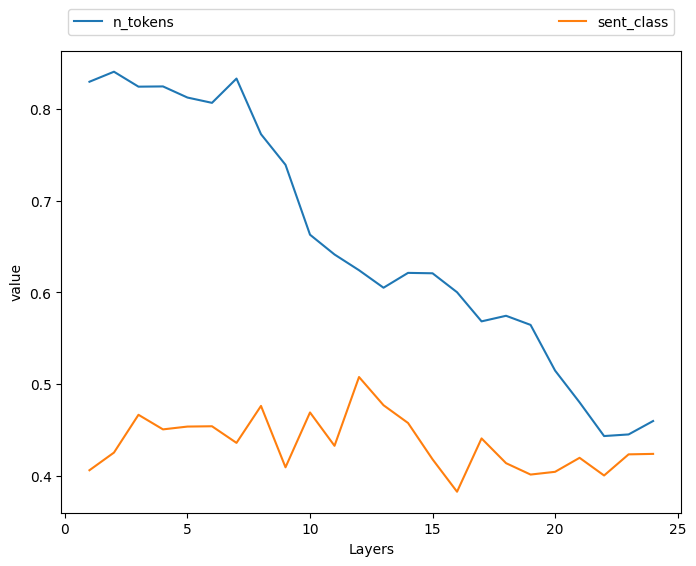

In [14]:
# Formatting the dataframe in order to be visualized as a multiline plot
results_df = results_df[layers]
results_df = results_df.T
results_df["Layers"] = results_df.index
plot_results = pd.melt(results_df, ["Layers"])

# Visualization with seaborn
fig, ax = plt.subplots(figsize=(8, 6))
g = sns.lineplot(data=plot_results, x="Layers", y="value", hue="variable")
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 1.02, 1., .102),
              loc='lower left', ncol=3, mode="expand")